# **Detección de Fraude en Transacciones de Tarjetas de Crédito**

## Definición del Problema

El fraude con tarjetas de crédito representa una amenaza significativa para la integridad de las transacciones financieras y la confianza de los consumidores en el comercio digital. A medida que la dependencia de las tarjetas de crédito para las compras diarias continúa creciendo, también lo hace la sofisticación de los estafadores que explotan las vulnerabilidades del sistema. Este proyecto tiene como objetivo aplicar técnicas de aprendizaje automático para la detección de fraudes en transacciones de tarjetas de crédito.  A lo largo del proyecto, se sigue un flujo de análisis y desarrollo orientado a la clasificación de transacciones como fraudulentas (clase 1) o no fraudulentas (clase 0).

### **Dataset**
- **Fuente**: Kaggle ...
- **Descripción**: El **Credit Card Fraud Dataset** es un conjunto de datos que comprende 100000 transacciones generadas para simular la actividad de las tarjetas de crédito en el mundo real. Cada entrada incluye las siguientes características:
    - **TransactionID**:  Un identificador único para cada transacción, que garantiza la trazabilidad.
    - **TransactionDate**: La fecha y hora en que se produjo la transacción, lo que permite el análisis temporal.
    - **Amount**: El valor monetario de la transacción, que puede ayudar a identificar transacciones inusualmente grandes que pueden indicar fraude.
    - **MerchantID**: Un identificador para el comerciante involucrado en la transacción, útil para evaluar patrones de fraude relacionados con el comerciante.
    - **TransactionType**: Indica si la transacción fue una compra o un reembolso, proporcionando contexto para la actividad.
    - **Location**: La ubicación geográfica de la transacción, lo que facilita el análisis de las tendencias de fraude por región.
    - **IsFraud**: Una variable objetivo binaria que indica si la transacción es fraudulenta (1) o legítima (0), esencial para los modelos de aprendizaje supervisado.

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [225]:
data = pd.read_csv("./data/credit_card_fraud_dataset.csv")
data.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [226]:
data.info()
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


TransactionID      100000
TransactionDate    100000
Amount              90621
MerchantID           1000
TransactionType         2
Location               10
IsFraud                 2
dtype: int64

In [227]:
#Verificar valores nulos
data.isnull().sum()
#El dataset no contiene valores nulos

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [228]:
#Verificar valores duplicados
data.duplicated().sum()
#El dataset no contiene valores duplicados

0

## **Análisis Exploratorio de Datos (EDA)**

In [229]:
data.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


####  Distribución de la variable objetivo: 
##### Transacciones fraudulentas vs. legítimas  (**Balance de clases**)

Distribución de transacciones:
IsFraud
0    99000
1     1000
Name: count, dtype: int64

Porcentajes:
IsFraud
0    99.0
1     1.0
Name: proportion, dtype: float64


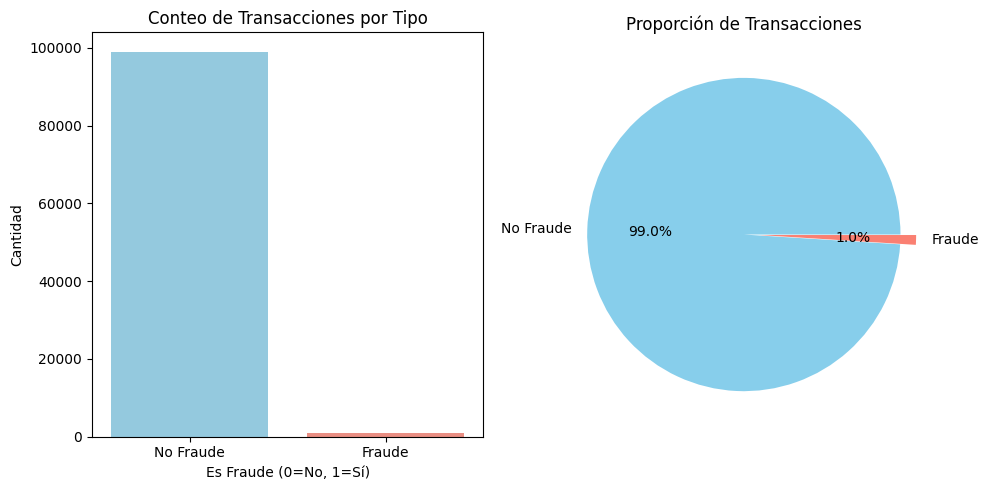

In [230]:
fraud_count = data['IsFraud'].value_counts()
fraud_percentage = data['IsFraud'].value_counts(normalize=True) * 100

print("Distribución de transacciones:")
print(fraud_count)
print("\nPorcentajes:")
print(fraud_percentage)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='IsFraud', data=data, hue='IsFraud', palette=['skyblue', 'salmon'], legend=False)
plt.title('Conteo de Transacciones por Tipo')
plt.xlabel('Es Fraude (0=No, 1=Sí)')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No Fraude', 'Fraude'])  # Hacemos las etiquetas más descriptivas

plt.subplot(1, 2, 2)
plt.pie(fraud_count, labels=['No Fraude', 'Fraude'], autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], explode=(0, 0.1))
plt.title('Proporción de Transacciones')
plt.tight_layout()  
plt.show()

**Resultados:**
- El dataset está extremadamente desbalanceado: 99% transacciones legítimas vs 1% fraudulentas.
- Se necesitarán técnicas especiales (oversampling, undersampling, class weighting) para manejar este desbalance.

### Análisis Temporal del Fraude

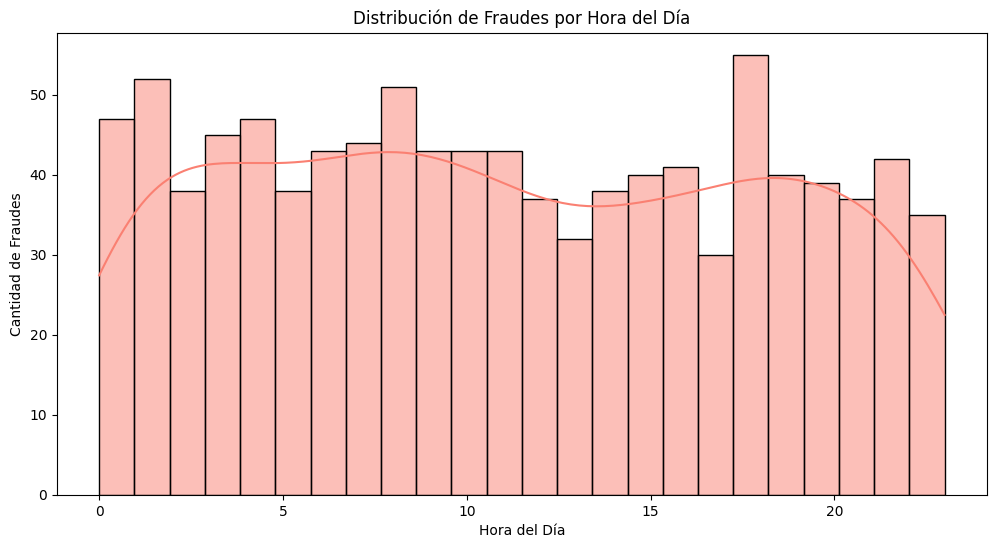

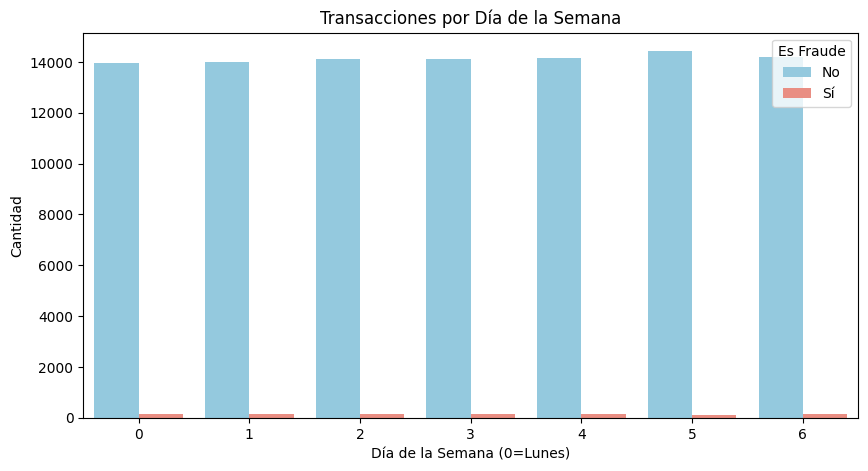

In [231]:
#Extraer componentes temporales
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['Hour'] = data['TransactionDate'].dt.hour
data['Day'] = data['TransactionDate'].dt.day
data['Month'] = data['TransactionDate'].dt.month
data['DayOfWeek'] = data['TransactionDate'].dt.dayofweek

#Fraude por hora del día
plt.figure(figsize=(12, 6))
sns.histplot(data=data[data['IsFraud']==1], x='Hour', bins=24, 
                kde=True, color='salmon')
plt.title('Distribución de Fraudes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Fraudes')
plt.show()

#Fraude por día de la semana
plt.figure(figsize=(10, 5))
sns.countplot(x='DayOfWeek', hue='IsFraud', data=data, 
                palette=['skyblue', 'salmon'])
plt.title('Transacciones por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes)')
plt.ylabel('Cantidad')
plt.legend(title='Es Fraude', labels=['No', 'Sí'])
plt.show()

#### Distribución del Monto en Transacciones Fraudulentas:
- ¿Hay diferencias significativas entre montos de transacciones fraudulentas y legítimas?
- ¿Existen valores atípicos (outliers) que puedan indicar posibles fraudes?


           count        mean          std   min        25%      50%       75%  \
IsFraud                                                                         
0        99000.0  2496.88992  1442.257175  1.05  1247.9550  2495.61  3742.855   
1         1000.0  2517.16444  1458.643653  5.56  1249.2775  2543.43  3813.850   

             max  
IsFraud           
0        4999.77  
1        4985.88  


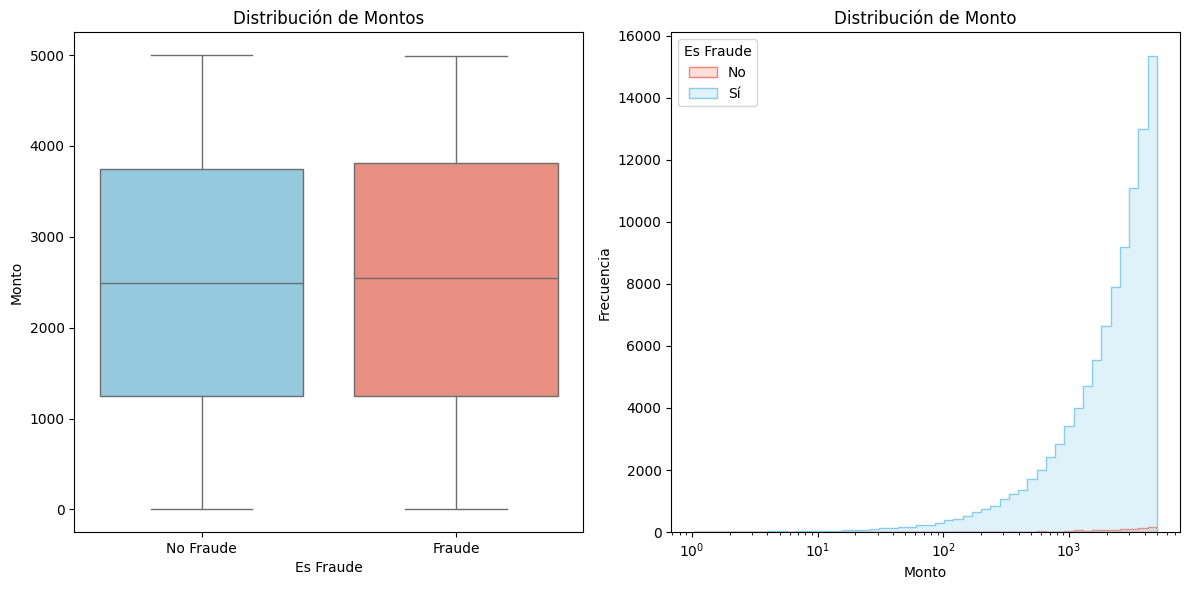

In [232]:
print(data.groupby('IsFraud')['Amount'].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='IsFraud', y='Amount', data=data, hue='IsFraud', 
            palette=['skyblue', 'salmon'], showfliers=True, legend=False)
plt.title('Distribución de Montos')
plt.ylabel('Monto')
plt.xlabel('Es Fraude')
plt.xticks([0, 1], ['No Fraude', 'Fraude'])

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='Amount', hue='IsFraud', 
                bins=50, element='step', common_norm=False,
                palette=['skyblue', 'salmon'], log_scale=True)
plt.title('Distribución de Monto')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.legend(title='Es Fraude', labels=['No', 'Sí'])

plt.tight_layout()
plt.show()

**Resultados**
- Las distribuciones son bastante similares en términos generales
- Las medianas y cuartiles sugieren que las transacciones fraudulentas podrían tener montos ligeramente más altos

El uso de escala logarítmica en estos gráficos se debe principalmente a:

1. **Gran variabilidad en los montos:** Las transacciones pueden ir desde unos pocos dólares hasta miles, lo que hace difícil visualizar adecuadamente la distribución en escala lineal.

2. **Distribución asimétrica (sesgada a la derecha):** La mayoría de las transacciones tienen montos bajos, pero hay algunas con valores muy altos que distorsionarían la visualización en escala normal.

#### Análisis geográfico (Location):
¿Hay ciudades con mayor incidencia de fraudes?

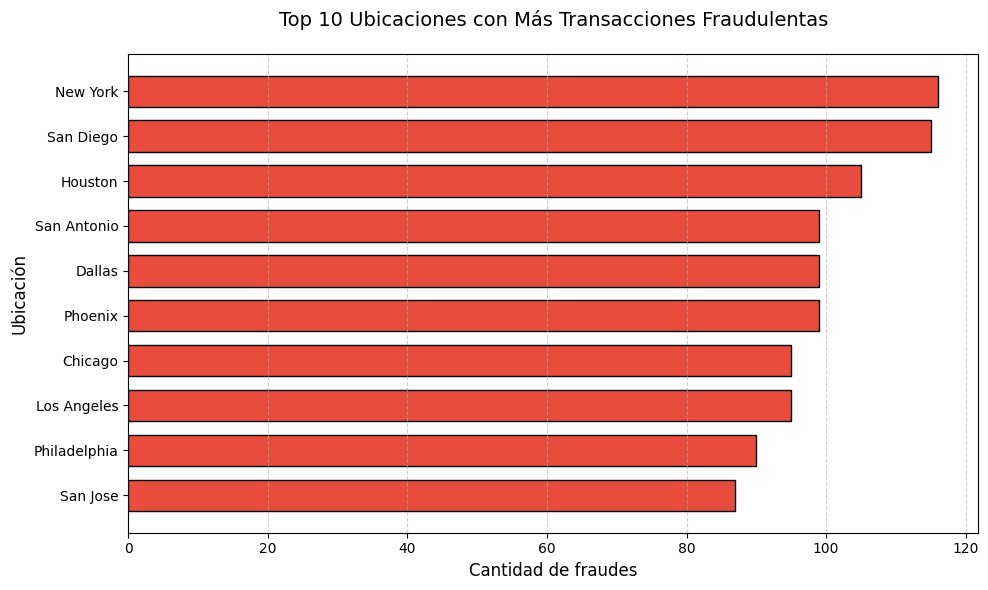

In [233]:
fraud_by_location = data[data['IsFraud'] == 1]['Location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.barh(
    fraud_by_location.index,
    fraud_by_location.values,
    color='#e74c3c',
    height=0.7,
    edgecolor='black'
)
plt.title('Top 10 Ubicaciones con Más Transacciones Fraudulentas', fontsize=14, pad=20)
plt.xlabel('Cantidad de fraudes', fontsize=12)
plt.ylabel('Ubicación', fontsize=12)
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

¿Hay comerciantes con mayor incidencia de fraudes?

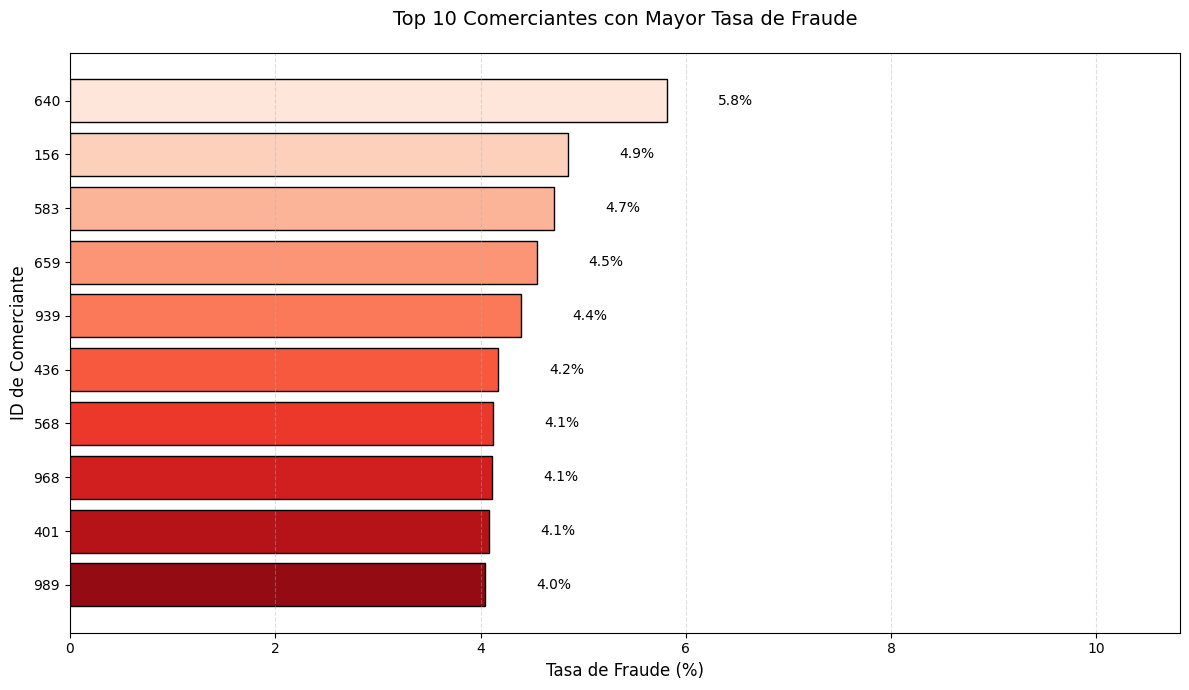

In [234]:
merchant_fraud_rate = (data.groupby('MerchantID')['IsFraud']
                        .mean()
                        .mul(100)  
                        .nlargest(10)
                        .sort_values())

plt.figure(figsize=(12, 7))

bars = plt.barh(merchant_fraud_rate.index.astype(str), merchant_fraud_rate.values,
                color=sns.color_palette('Reds_r', 10), edgecolor='black')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', va='center', fontsize=10)

plt.title('Top 10 Comerciantes con Mayor Tasa de Fraude', fontsize=14, pad=20)
plt.xlabel('Tasa de Fraude (%)', fontsize=12)
plt.ylabel('ID de Comerciante', fontsize=12)
plt.xlim(0, merchant_fraud_rate.max() + 5)  
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Distribución de Tipos de Transacción:
- ¿Cuál es la distribución de tipos de transacción en general?
- ¿Hay algún tipo de transacción **(compra, reembolso)** más asociado al fraude?

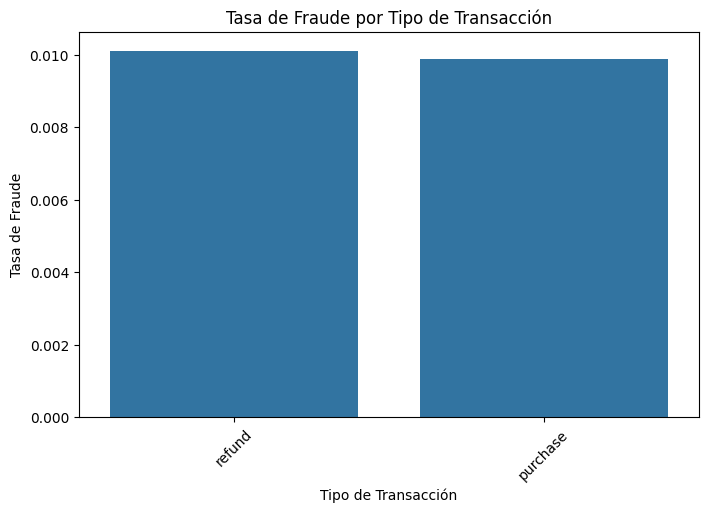

In [235]:
transaction_type_fraud = data.groupby('TransactionType')['IsFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=transaction_type_fraud.index, y=transaction_type_fraud.values)
plt.title('Tasa de Fraude por Tipo de Transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Tasa de Fraude')
plt.xticks(rotation=45)
plt.show()

## **Preprocesamiento de los Datos**
Se realiza mediante la estandarización de formatos, el escalado de valores y la codificación de variables categóricas, creando un conjunto de datos coherente y bien organizado. El objetivo es refinar los datos brutos en un formato que sea significativo para el análisis y la formación. Mediante la limpieza y el preprocesamiento de datos, nos aseguramos de que el modelo se entrene con datos fiables y de alta calidad.

Eliminar Columnas No Relevantes

In [236]:
features_to_drop = ['TransactionID', 'TransactionDate', 'MerchantID']
df_processed = data.drop(columns=features_to_drop)

#### Codificación de variables categóricas
Las variables como **TransactionType** y **Location** son categóricos (texto), los modelos de ML no trabajan con texto, lo que implica que estas variables deben convertirse a números.

- One-Hot Encoding (para categorías con pocos valores)

In [237]:
df_processed = pd.get_dummies(df_processed, columns=['TransactionType', 'Location'], drop_first=True) #drop_first=True es para evitar redundancia (ej. si no es compra, es reembolso).

## **Selección y Entrenamiento del Modelo**

In [239]:
X = df_processed.drop('IsFraud', axis=1)
y = df_processed['IsFraud']

In [240]:
#stratify=y para mantener proporción de fraudes
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

##### Normalización/Estandarización de Variables Numéricas
Como el conjunto de datos contiene valores numéricos, primero debemos normalizar los datos. El propósito de la normalización es hacer que todos los atributos numéricos estén en una escala común. 

Variables como **Amount** están en escalas totalmente diferentes. Esto sesga los modelos (ej: SVM, KNN o redes neuronales).


El StandardScaler:
- Calcula la media (μ) y la desviación estándar (σ) de los datos.
- Aplica la fórmula (x - μ) / σ a cada valor.

**¿Qué pasa si normalizas ANTES de dividir?**
1. Calculas la media y la desviación estándar usando TODOS tus datos, incluyendo el conjunto de prueba.

2. Esto significa que la información del conjunto de prueba (su media, su distribución) se ha "filtrado" al proceso de entrenamiento.

3. El modelo ya tiene una "pista" sobre cómo son los datos del examen antes de verlo.

El resultado es una evaluación demasiado optimista. Tu modelo parecerá funcionar muy bien en tu conjunto de prueba, pero cuando lo despliegues en el mundo real con datos verdaderamente nuevos, su rendimiento será peor de lo que esperabas.


In [242]:
scaler = StandardScaler()

X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_val['Amount'] = scaler.transform(X_val[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])